In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
root = '/gdrive/My Drive/Dogus_datathon/'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

Mounted at /gdrive
/gdrive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#1.Data

In [ ]:
train_sett = pd.read_csv(root + 'zingat_usecase_trainset.csv')
test_sett = pd.read_csv(root + 'zingat_usecase_testset_null.csv')

In [ ]:
train_sett

,tarih,path,güncel_fiyat,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu,Ilan_ID
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,1050000 TRY,5+2,380.0,370.0,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,VAR,VAR,VAR,1
1,2019-01-01,İstanbul/Kadıköy/Erenköy,547500 TRY,2+1,65.0,55.0,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,VAR,YOK,VAR,YOK,YOK,YOK,11
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,440000 TRY,3+1,205.0,197.0,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,YOK,YOK,VAR,10
3,2019-01-01,İstanbul/Beşiktaş/Nisbetiye,1450000 TRY,3+1,150.0,130.0,Daire,26-30 arası,3,5,Merkezi Sistem (Isı Payı Ölçer),2,"Cadde,Şehir","Var (Ücretsiz, Açık)",YOK,YOK,VAR,YOK,YOK,VAR,8
4,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,169000 TRY,2+1,70.0,65.0,Daire,1,Kot 1,6,Kombi (Doğalgaz),1,"Boğaz,Deniz,Göl,Doğa",Var,VAR,YOK,VAR,YOK,VAR,VAR,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64568,2020-04-19,İzmir/Seferihisar/Bengiler,790000 TRY,3+1,180.0,174.0,Yazlık,0,Müstakil,3,Klima,2,_,Var,YOK,VAR,YOK,YOK,YOK,YOK,64558
64569,2020-04-19,İzmir/Karabağlar/Vatan,340000 TRY,3+1,130.0,125.0,Daire,6-10 arası,2,4,Kalorifer (Doğalgaz),2,_,Yok,YOK,VAR,YOK,YOK,YOK,YOK,64557
64570,2020-04-19,İzmir/Seferihisar/Bengiler,620000 TRY,3+1,180.0,175.0,Villa,0,Müstakil,3,Klima,2,_,Var,YOK,VAR,YOK,YOK,YOK,YOK,64556
64571,2020-04-19,İzmir/Karşıyaka/Donanmacı,750000 TRY,3+1,125.0,115.0,Daire,0,1,6,Kombi (Elektrikli),2,_,-,YOK,VAR,YOK,VAR,VAR,VAR,64555


In [ ]:
train_set = pd.concat([train_sett, test_sett], axis=0)

Useless data was dropped.

In [ ]:
train_set.drop("Ilan_ID", axis=1, inplace=True)

In [ ]:
train_label_set = train_set["güncel_fiyat"]
train_set = train_set.drop("güncel_fiyat", axis=1)

In [ ]:
train_set.head()

,tarih,path,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu
0,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,5+2,380.0,370.0,Daire,16-20 arası,12,10-20 arası,Kombi (Doğalgaz),3,"Cadde,Deniz,Göl","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,VAR,VAR,VAR
1,2019-01-01,İstanbul/Kadıköy/Erenköy,2+1,65.0,55.0,Daire,0,1,7,Kombi (Doğalgaz),1,_,-,VAR,YOK,VAR,YOK,YOK,YOK
2,2019-01-01,İstanbul/Beylikdüzü/Adnan Kahveci,3+1,205.0,197.0,Daire,11-15 arası,2,10-20 arası,Kombi (Doğalgaz),2,"Cadde,Şehir","Var (Ücretsiz, Kapalı)",VAR,VAR,VAR,YOK,YOK,VAR
3,2019-01-01,İstanbul/Beşiktaş/Nisbetiye,3+1,150.0,130.0,Daire,26-30 arası,3,5,Merkezi Sistem (Isı Payı Ölçer),2,"Cadde,Şehir","Var (Ücretsiz, Açık)",YOK,YOK,VAR,YOK,YOK,VAR
4,2019-01-01,İstanbul/Beylikdüzü/Cumhuriyet,2+1,70.0,65.0,Daire,1,Kot 1,6,Kombi (Doğalgaz),1,"Boğaz,Deniz,Göl,Doğa",Var,VAR,YOK,VAR,YOK,VAR,VAR


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99700 entries, 0 to 35126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tarih                     99700 non-null  object 
 1   path                      99700 non-null  object 
 2   odasayısı                 99700 non-null  object 
 3   brütm²                    99700 non-null  float64
 4   netm²                     99700 non-null  float64
 5   emlaktipi                 99700 non-null  object 
 6   binayaşı                  99700 non-null  object 
 7   bulunduğukat              99700 non-null  object 
 8   binadakikatsayısı         99700 non-null  object 
 9   isıtmatipi                99700 non-null  object 
 10  banyosayisi               99700 non-null  object 
 11  manzara                   99700 non-null  object 
 12  otopark                   99700 non-null  object 
 13  İnterkom                  99700 non-null  object 
 14  deprem

In [ ]:
train_set.nunique()

tarih                        731
path                         884
odasayısı                     41
brütm²                       822
netm²                        554
emlaktipi                      9
binayaşı                      15
bulunduğukat                  35
binadakikatsayısı             13
isıtmatipi                    17
banyosayisi                    8
manzara                     1036
otopark                        8
İnterkom                       2
depremyönetmeliğineuygun       2
asansör                        2
Çocukoyunalanı                 2
giyinmeodası                   2
ebeveynbanyosu                 2
dtype: int64

#2.Data Cleaning

## 2.1 Missing Values

In [ ]:
train_set.isnull().sum()*100/train_set.shape[0]

tarih                       0.0
path                        0.0
odasayısı                   0.0
brütm²                      0.0
netm²                       0.0
emlaktipi                   0.0
binayaşı                    0.0
bulunduğukat                0.0
binadakikatsayısı           0.0
isıtmatipi                  0.0
banyosayisi                 0.0
manzara                     0.0
otopark                     0.0
İnterkom                    0.0
depremyönetmeliğineuygun    0.0
asansör                     0.0
Çocukoyunalanı              0.0
giyinmeodası                0.0
ebeveynbanyosu              0.0
dtype: float64

In [ ]:
for i in ["brütm²","netm²"]:
    print("{} sütunu için problemli değerler : ".format(i))
    hatali_degerler = []
    for deger in train_set[i]:
        try:
            float(deger)
        except:
            hatali_degerler.append(deger)
    print(set(hatali_degerler)) #Nümerik verilerde hatali değer yoktur.

brütm² sütunu için problemli değerler : 
set()
netm² sütunu için problemli değerler : 
set()


When the data was analyzed in Excel, it was observed that the data in some columns were "-". These columns are listed below. These missing values were filled with the data's mod or mean operations.

In [ ]:
eksik_degerli = train_set[(train_set["odasayısı"].str.strip() == "-") | (train_set["binayaşı"].str.strip() == "-") | (train_set["binadakikatsayısı"].str.strip() == "-")| (train_set["banyosayisi"].str.strip() == "-")]
display(eksik_degerli.head())
print('Eksik değerli kayıt satır sayısı : ',  len(eksik_degerli))

,tarih,path,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu
9,2019-01-01,İzmir/Torbalı/Dirmil,1+1,67.0,42.0,Müstakil Ev,-,-,-,-,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK
10,2019-01-01,İzmir/Menemen/Ulus,3+1,130.0,115.0,Daire,-,4,7,Kombi (Doğalgaz),2,_,Var,VAR,YOK,VAR,VAR,YOK,YOK
46,2019-01-02,İstanbul/Beylikdüzü/Cumhuriyet,3+1,130.0,120.0,Daire,0,3,-,Kombi (Doğalgaz),1,Cadde,Var,YOK,VAR,VAR,YOK,YOK,YOK
69,2019-01-02,İzmir/Çiğli/Ataşehir,4+1,260.0,240.0,Daire,-,-,-,-,2,_,-,YOK,YOK,YOK,YOK,YOK,YOK
101,2019-01-02,İzmir/Torbalı/Fevzi Çakmak,2+1,85.0,80.0,Daire,-,-,-,-,1,_,-,YOK,YOK,YOK,YOK,YOK,YOK


Eksik değerli kayıt satır sayısı :  5970


### 2.1.1 Missing Values Oda sayısı (Eksik değer mean ile dolduruldu.)

In [ ]:
room_number_list = []
count = 0
for i in train_set["odasayısı"].str.split("+").tolist():
  try:
    int_dizi = [int(x) for x in i]
    room_number_list.append(int_dizi[0]+int_dizi[1])
  except ValueError:
    pass
room_number_list_mean = np.mean(room_number_list)

In [ ]:
room_number_list = []
for i in train_set["odasayısı"].str.split("+").tolist():
  try:
    int_dizi = [int(x) for x in i]
    room_number_list.append(int_dizi[0]+int_dizi[1])
  except ValueError:
    room_number_list.append(room_number_list_mean)
train_set["odasayısı"] = room_number_list

### 2.1.2 Missing Values bina yaşı(Eksik değer mod ile dolduruldu.)

In [ ]:
train_set["binayaşı"] = train_set["binayaşı"].replace("-", str(train_set.mode()["binayaşı"])[0])

### 2.1.3 Missing Values binadaki kat sayısı(Eksik değer mod ile dolduruldu.)

In [ ]:
train_set["binadakikatsayısı"] = train_set["binadakikatsayısı"].replace("-", str(train_set.mode()["binadakikatsayısı"])[0])

### 2.1.4 Missing Values banyo sayısı(Eksik değer mod ile dolduruldu.)

In [ ]:
train_set["banyosayisi"] = train_set["banyosayisi"].replace("-", str(train_set.mode()["banyosayisi"])[0])

## 2.2 Outlier

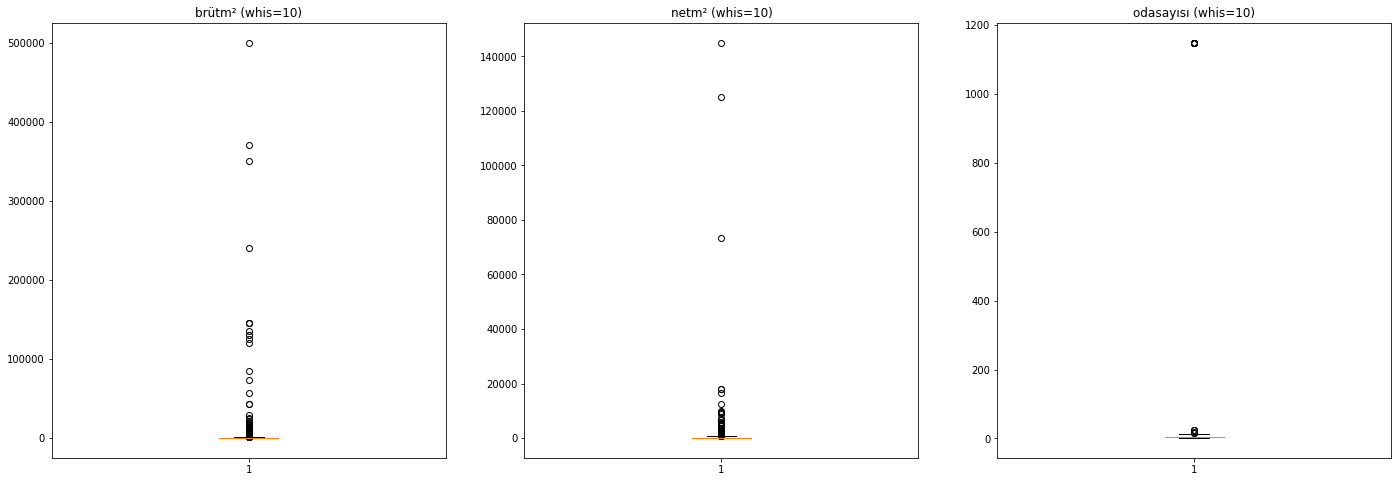

In [ ]:
plt.figure(figsize=(24,8))
count = 0
for i in ["brütm²","netm²","odasayısı"]:
  count+=1
  plt.subplot(1,3,count)
  plt.boxplot(train_set[i], whis=10)
  plt.title(f"{i} (whis=10)")

plt.show()

### 2.2.1 Outlier (Winsorize)

{'boxes': [<matplotlib.lines.Line2D at 0x7f7c487f9910>],
 'caps': [<matplotlib.lines.Line2D at 0x7f7c487fd990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7c487839d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7c48783490>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7c487f9ed0>,
  <matplotlib.lines.Line2D at 0x7f7c487fd450>]}

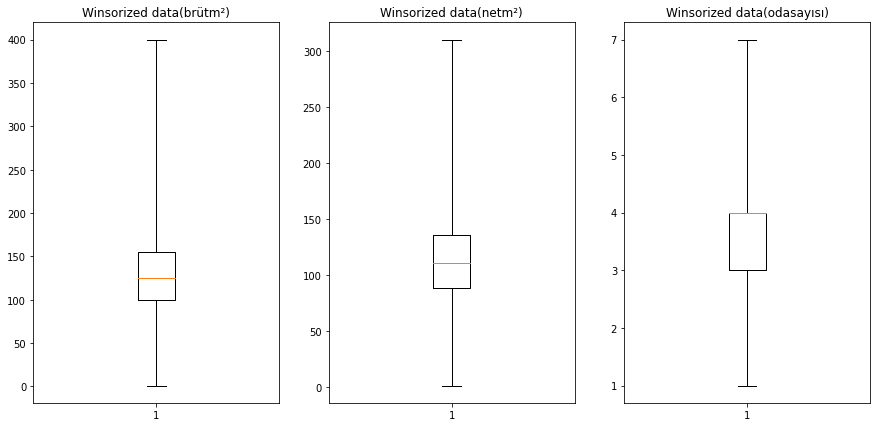

In [ ]:
train_set["brütm²"] = winsorize(train_set["brütm²"], (0, 0.02))
train_set["netm²"] = winsorize(train_set["netm²"], (0, 0.02))
train_set["odasayısı"] = winsorize(train_set["odasayısı"], (0, 0.02))

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("Winsorized data(brütm²)")
plt.boxplot(train_set["brütm²"], whis=10)
plt.subplot(1,3,2)
plt.title("Winsorized data(netm²)")
plt.boxplot(train_set["netm²"], whis=10)
plt.subplot(1,3,3)
plt.title("Winsorized data(odasayısı)")
plt.boxplot(train_set["odasayısı"], whis=10)
# Aykırılık giderildi.

### 2.2.2 Outlayer Güncel Fiyat (Target Value)

In [ ]:
train_label_set = train_label_set.dropna() # Test setinde güncel fiyatlar bilgisi bulunmadığı için buradaki NaN değerler drop edildi.

Güncel fiyat kısmında veri "fiyat" ve "para birimi" cinsinden verildiğinden sadece "fiyat" verisi olacak şekilde güncellendi.

In [ ]:
train_label_set = pd.DataFrame(train_label_set.str.split(" ").tolist(), columns=["guncel_fiyat", "para_birimi"], index=train_label_set.index)
train_label_set['guncel_fiyat'] = train_label_set['guncel_fiyat'].astype('int64')
train_label_set = train_label_set.drop("para_birimi", axis=1)

{'boxes': [<matplotlib.lines.Line2D at 0x7f7c48877150>],
 'caps': [<matplotlib.lines.Line2D at 0x7f7c4881b610>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7c488b5410>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7c4884bb10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7c488b6090>,
  <matplotlib.lines.Line2D at 0x7f7c48841e50>]}

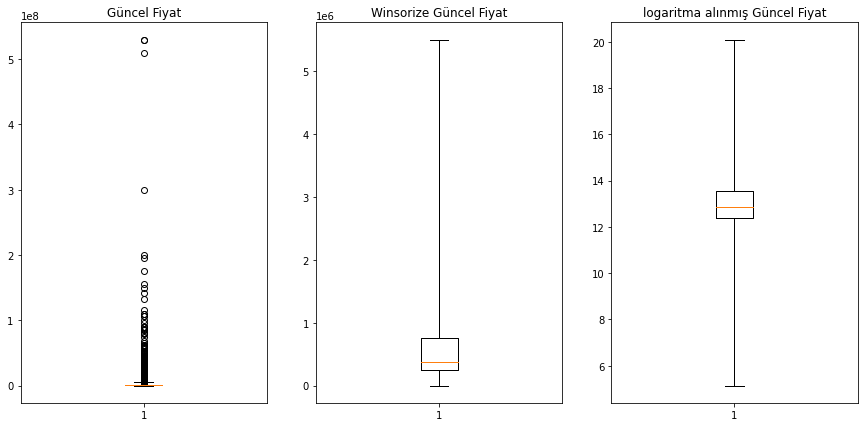

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.title("Güncel Fiyat")
plt.boxplot(train_label_set["guncel_fiyat"], whis=10)

train_label_set["winsorize_guncel_fiyat"] = winsorize(train_label_set["guncel_fiyat"], (0, 0.02))
plt.subplot(1,3,2)
plt.title("Winsorize Güncel Fiyat")
plt.boxplot(train_label_set["winsorize_guncel_fiyat"], whis=10)

train_label_set["logaritma_guncel_fiyat"] = np.log(train_label_set["guncel_fiyat"])
plt.subplot(1,3,3)
plt.title("logaritma alınmış Güncel Fiyat")
plt.boxplot(train_label_set["logaritma_guncel_fiyat"], whis=10)

Not: Data exploration kısmındaki sonuçlara göre en mantıklı olan seçilecek.

# 3.Data Exploration

## 3.1 One Variable Analysis

In [ ]:
train_set.describe(include="all")

,tarih,path,odasayısı,brütm²,netm²,emlaktipi,binayaşı,bulunduğukat,binadakikatsayısı,isıtmatipi,banyosayisi,manzara,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu
count,99700,99700,99700.000000,99700.000000,99700.000000,99700,99700,99700,99700,99700,99700,99700,99700,99700,99700,99700,99700,99700,99700
unique,731,884,NaN,NaN,NaN,9,14,35,13,17,7,1036,8,2,2,2,2,2,2
top,2020-03-16,İstanbul/Beylikdüzü/Cumhuriyet,NaN,NaN,NaN,Daire,0,2,4,Kombi (Doğalgaz),1,_,-,YOK,YOK,YOK,YOK,YOK,YOK
freq,451,6649,NaN,NaN,NaN,87182,41944,15586,20476,55146,54555,65688,54264,58427,80953,50387,88211,87534,69003
mean,NaN,NaN,3.742734,140.866830,119.263220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,1.077299,67.925002,52.418724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.000000,100.000000,88.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.000000,125.000000,110.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.000000,155.000000,135.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.1.1 Continous Variable Visualization

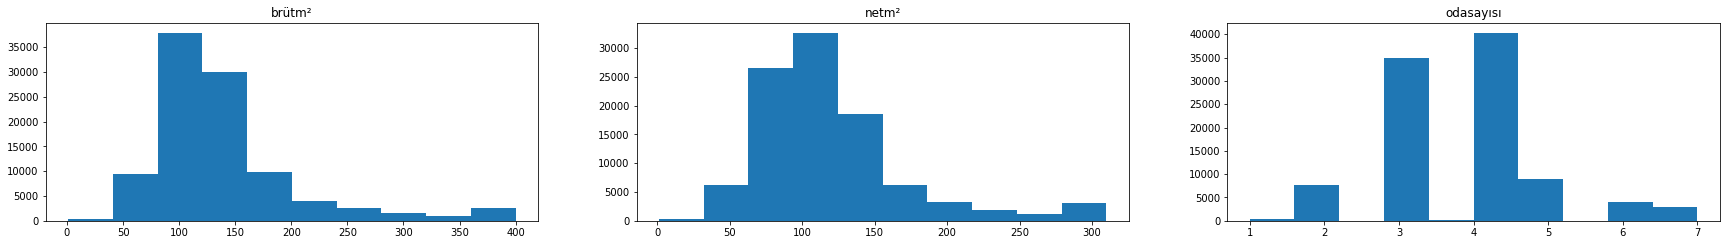

In [ ]:
plt.figure(figsize=(30,8))

degiskenler = ["brütm²","netm²","odasayısı"]

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.hist(train_set[degiskenler[i]])
    plt.title(degiskenler[i])

Not: Winsorize Edilmiş değişkenler normal dağılıma uygun görülmüştür.

Text(0.5, 1.0, 'logaritmalı winsorize_guncel_fiyat')

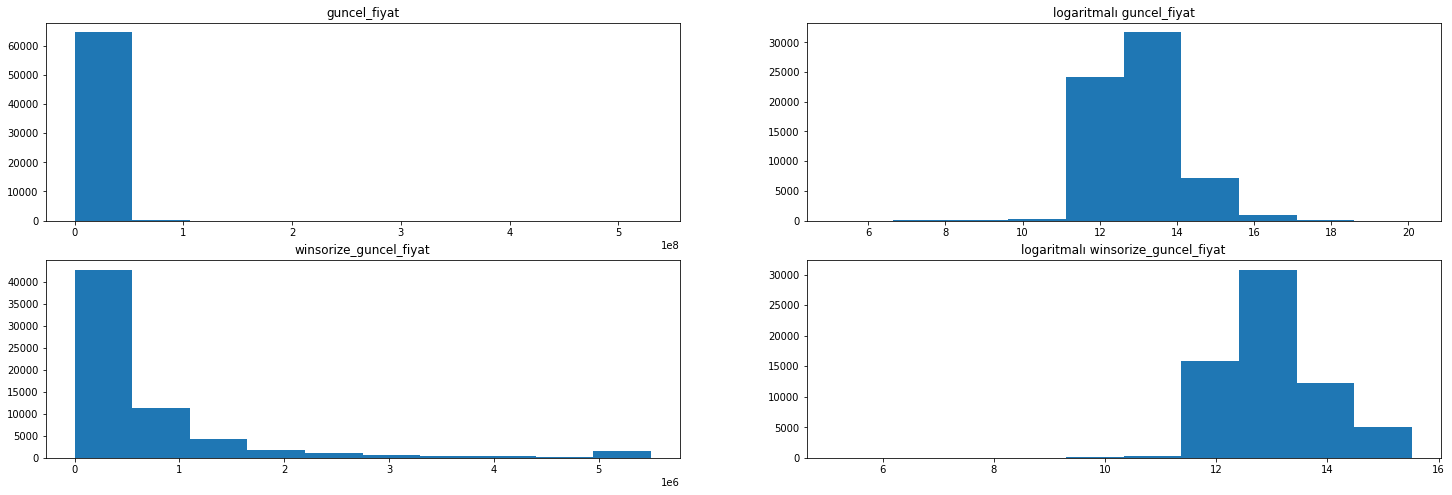

In [ ]:
plt.figure(figsize=(25,8))

plt.subplot(2,2,1)
plt.hist(train_label_set["guncel_fiyat"])
plt.title("guncel_fiyat")

plt.subplot(2,2,2)
plt.hist(train_label_set["logaritma_guncel_fiyat"])
plt.title("logaritmalı guncel_fiyat")

plt.subplot(2,2,3)
plt.hist(train_label_set["winsorize_guncel_fiyat"])
plt.title("winsorize_guncel_fiyat")

plt.subplot(2,2,4)
plt.hist(np.log(train_label_set["winsorize_guncel_fiyat"]))
plt.title("logaritmalı winsorize_guncel_fiyat")

Not: Logaritmalı güncel fiyat daha çok normal dağılıma benzemektedir.

### 3.1.2 Categorical Variable Visualization

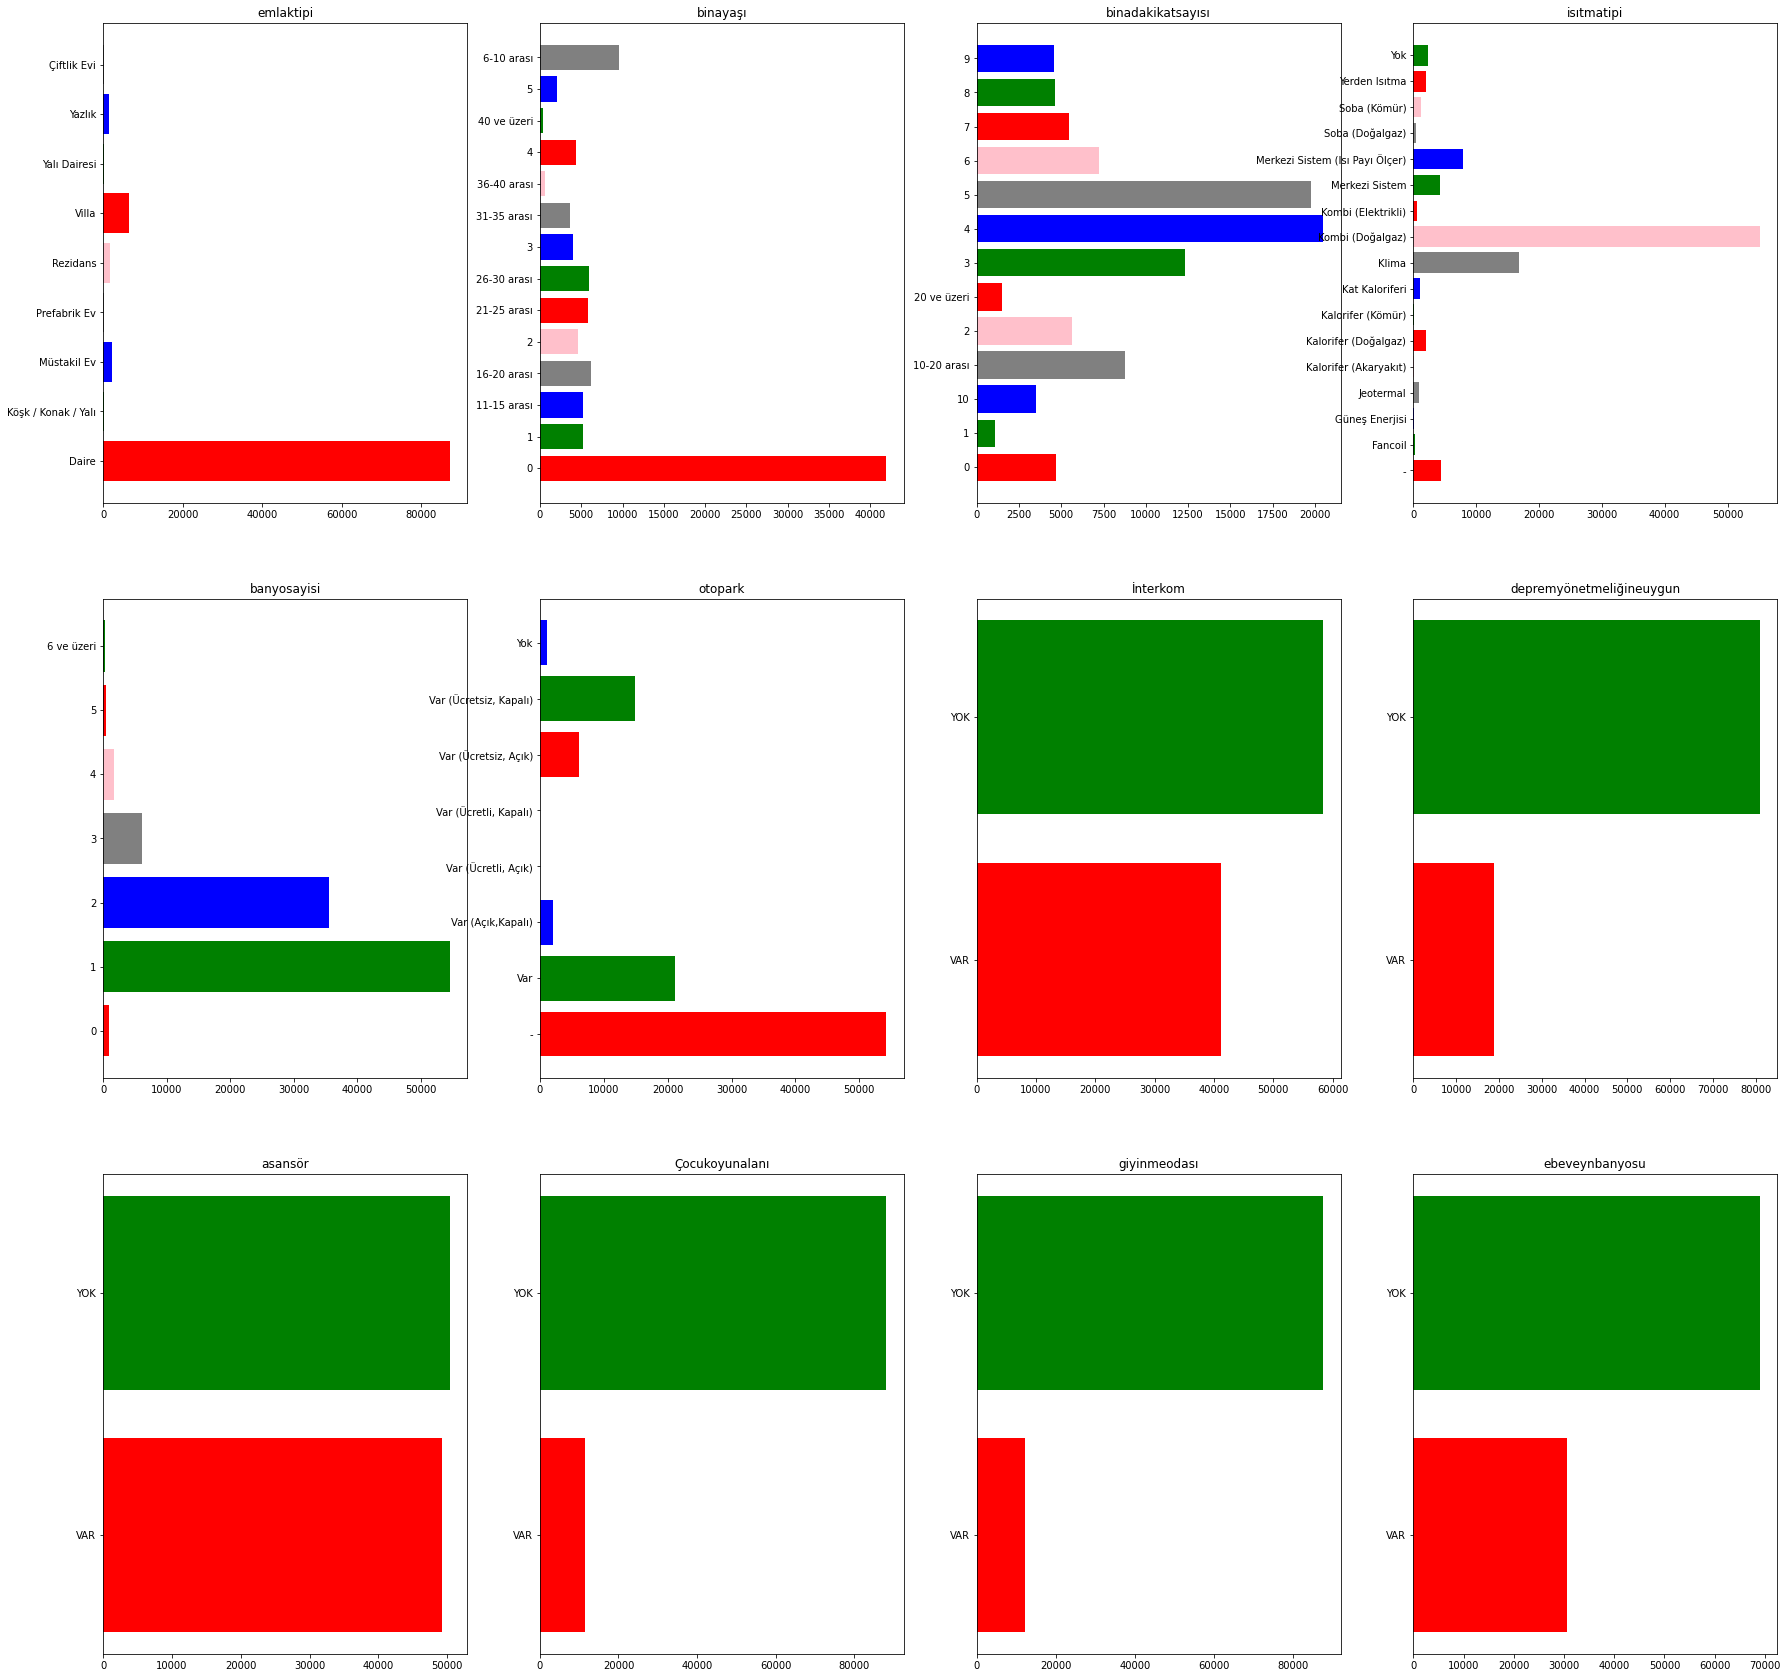

In [ ]:
plt.figure(figsize=(30,30))
categorical_variables = ["emlaktipi", "binayaşı", "binadakikatsayısı", "isıtmatipi", "banyosayisi", "otopark", "İnterkom","depremyönetmeliğineuygun","asansör","Çocukoyunalanı","giyinmeodası","ebeveynbanyosu"]
for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.barh(train_set.groupby(categorical_variables[i])[categorical_variables[i]].count().index, 
      train_set.groupby(categorical_variables[i])[categorical_variables[i]].count(), 
      color=["red","green","blue","grey","pink"])
  plt.title(categorical_variables[i])

## 3.2 Multi Variable Analysis

### 3.2.1 Contiuous Variables

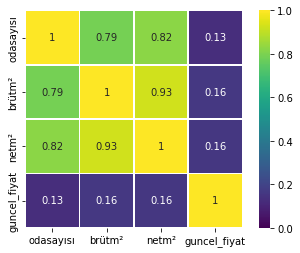

In [ ]:
train_set["guncel_fiyat"] = train_label_set["guncel_fiyat"]

sns.heatmap(train_set.corr(), square=True, annot=True, linewidths=.5, vmin=0, vmax=1, cmap='viridis')

### 3.2.2 Continuous-Categorical Variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

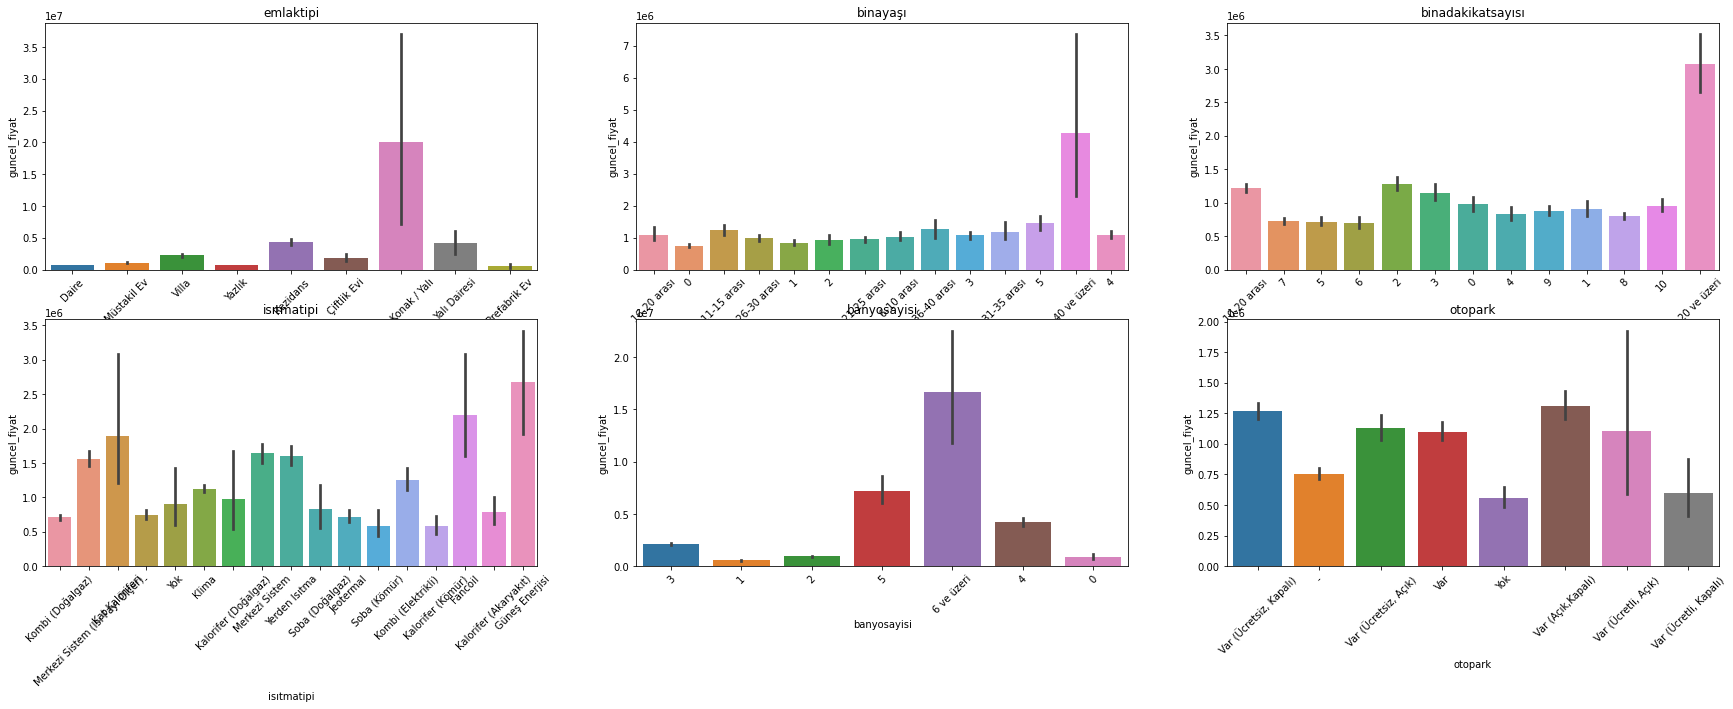

In [ ]:
categorical_colums = ["emlaktipi", "binayaşı", "binadakikatsayısı", "isıtmatipi", "banyosayisi", "otopark"]
plt.figure(figsize=(30,10))

for i in range(6):
  i = i + 1
  plt.subplot(2,3,i)
  sns.barplot(train_set[categorical_colums[i-1]], train_set["guncel_fiyat"])
  plt.title(f"{categorical_colums[i-1]}")
  plt.xticks(rotation=45)

plt.show()

# 4.Feature Engineering

## 4.1 Tarih Dolar Bağlantısı(Belirtilen tarihteki dolar kuru bilgisi eklendi.)

In [ ]:
usd = pd.read_csv(root + 'USD-TRY.csv')
usd.head()

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Fark %
0,31.12.2020,"7,4320","7,3815","7,4983","7,3444","0,74%"
1,30.12.2020,"7,3774","7,3865","7,3993","7,3030","-0,06%"
2,29.12.2020,"7,3815","7,4466","7,4804","7,3376","-0,81%"
3,28.12.2020,"7,4416","7,5716","7,5756","7,4035","-1,40%"
4,27.12.2020,"7,4416","7,5716","7,5756","7,4035","-1,40%"


In [ ]:
date_list = []
for i in usd["Tarih"]:
    y = i.split(".")
    new_date = f"{y[2]}-{y[1]}-{y[0]}"
    date_list.append(new_date)
usd_df = pd.DataFrame(date_list, columns=["tarih"], index=usd.index)
usd_df = pd.concat([usd_df,usd["Şimdi"]], axis=1)

In [ ]:
train_set = pd.merge(train_set, usd_df, on="tarih", how="left").set_index(train_set.index)
train_set = train_set.drop(["tarih"],axis=1)
train_set["dolar"] = train_set["Şimdi"].str.replace(",", ".").astype("float64")

## 4.2 Path (Konum olarak sadece ilçe verisi alındı.)

In [ ]:
path_list_town = []
for i in train_set.path.str.split("/"):
  try:
    path_list_town.append(i[1])
  except IndexError:
    path_list_town.append("YOK")
train_path_list_town_df = pd.DataFrame(path_list_town, columns=["path_town"], index=train_set.index)

## 4.3 Manzara

In [ ]:
mlb = MultiLabelBinarizer()
train_scene_df = pd.DataFrame(mlb.fit_transform(train_set["manzara"].str.split(",")), columns=mlb.classes_, index=train_set.index)

## 4.4 Binary Columns
- Interkom 
- Deprem 
- Asansör 
- Çocuk oyun alanı 
- Giyinme Odası
- Ebeveyn Banyosu

In [ ]:
train_some_df = train_set.loc[:,["İnterkom","depremyönetmeliğineuygun","asansör","Çocukoyunalanı","giyinmeodası","ebeveynbanyosu"]]
train_some_df['İnterkom'].loc[train_some_df['İnterkom'] == 'YOK'] = 0
train_some_df['İnterkom'].loc[train_some_df['İnterkom'] == 'VAR'] = 1
train_some_df['depremyönetmeliğineuygun'].loc[train_some_df['depremyönetmeliğineuygun'] == 'YOK'] = 0
train_some_df['depremyönetmeliğineuygun'].loc[train_some_df['depremyönetmeliğineuygun'] == 'VAR'] = 1
train_some_df['asansör'].loc[train_some_df['asansör'] == 'YOK'] = 0
train_some_df['asansör'].loc[train_some_df['asansör'] == 'VAR'] = 1
train_some_df['Çocukoyunalanı'].loc[train_some_df['Çocukoyunalanı'] == 'YOK'] = 0
train_some_df['Çocukoyunalanı'].loc[train_some_df['Çocukoyunalanı'] == 'VAR'] = 1
train_some_df['giyinmeodası'].loc[train_some_df['giyinmeodası'] == 'YOK'] = 0
train_some_df['giyinmeodası'].loc[train_some_df['giyinmeodası'] == 'VAR'] = 1
train_some_df['ebeveynbanyosu'].loc[train_some_df['ebeveynbanyosu'] == 'YOK'] = 0
train_some_df['ebeveynbanyosu'].loc[train_some_df['ebeveynbanyosu'] == 'VAR'] = 1
train_some_df = train_some_df.astype('int8')

## 4.5 Veri Birleştirme(İstenen Özelliklerin Seçilmesi)

In [ ]:
dfList = [train_path_list_town_df, train_set["odasayısı"], train_set["brütm²"], train_set["netm²"], train_set["emlaktipi"], train_set['binayaşı'], train_set["binadakikatsayısı"], train_set['isıtmatipi'], train_set["banyosayisi"], train_scene_df, train_set["otopark"], train_some_df, train_set["dolar"]]  
features_df = pd.concat(dfList, axis= 1)

In [ ]:
features_df

,path_town,odasayısı,brütm²,netm²,emlaktipi,binayaşı,binadakikatsayısı,isıtmatipi,banyosayisi,Boğaz,Cadde,Dağ,Deniz,Doğa,Göl,Havuz,Nehir,Park,Vadi,Yeşil Alan,_,Şehir,otopark,İnterkom,depremyönetmeliğineuygun,asansör,Çocukoyunalanı,giyinmeodası,ebeveynbanyosu,dolar
0,Beylikdüzü,7.0,380.0,310.0,Daire,16-20 arası,10-20 arası,Kombi (Doğalgaz),3,0,1,0,1,0,1,0,0,0,0,0,0,0,"Var (Ücretsiz, Kapalı)",1,1,1,1,1,1,5.2933
1,Kadıköy,3.0,65.0,55.0,Daire,0,7,Kombi (Doğalgaz),1,0,0,0,0,0,0,0,0,0,0,0,1,0,-,1,0,1,0,0,0,5.2933
2,Beylikdüzü,4.0,205.0,197.0,Daire,11-15 arası,10-20 arası,Kombi (Doğalgaz),2,0,1,0,0,0,0,0,0,0,0,0,0,1,"Var (Ücretsiz, Kapalı)",1,1,1,0,0,1,5.2933
3,Beşiktaş,4.0,150.0,130.0,Daire,26-30 arası,5,Merkezi Sistem (Isı Payı Ölçer),2,0,1,0,0,0,0,0,0,0,0,0,0,1,"Var (Ücretsiz, Açık)",0,0,1,0,0,1,5.2933
4,Beylikdüzü,3.0,70.0,65.0,Daire,1,6,Kombi (Doğalgaz),1,1,0,0,1,1,1,0,0,0,0,0,0,0,Var,1,0,1,0,1,1,5.2933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35122,Urla,5.0,200.0,180.0,Villa,11-15 arası,3,Klima,2,0,0,0,0,0,0,0,0,0,0,0,1,0,-,0,0,0,0,0,0,7.4320
35123,Bağcılar,3.0,85.0,65.0,Daire,21-25 arası,5,Kombi (Doğalgaz),1,0,0,0,0,0,0,0,0,0,0,0,1,0,-,0,0,0,0,0,0,7.4320
35124,Seferihisar,4.0,125.0,120.0,Daire,2,4,Kombi (Doğalgaz),2,0,0,0,0,0,0,0,0,0,0,0,1,0,-,0,0,1,0,0,0,7.4320
35125,Foça,7.0,400.0,245.0,Müstakil Ev,40 ve üzeri,2,Soba (Doğalgaz),1,0,0,0,0,0,0,0,0,0,0,0,1,0,Yok,0,0,0,0,0,0,7.4320


## 4.6 Kategorik Değişkenleri Dönüştürme

In [ ]:
categorical_colums = ["path_town", "emlaktipi", "binayaşı", "binadakikatsayısı", "isıtmatipi", "banyosayisi", "otopark"]
features_df = pd.get_dummies(features_df, columns=categorical_colums)

## 4.7 Normalization and Standard Scaling

### 4.7.1 Case 1 Normalization

In [ ]:
"""numerical_columns = ["odasayısı", "brütm²", "netm²", "dolar"]
mm_sc = MinMaxScaler()
for i in range(4):
  features_df[numerical_columns[i]] = mm_sc.fit_transform(features_df[[numerical_columns[i]]])"""

'numerical_columns = ["odasayısı", "brütm²", "netm²", "dolar"]\nmm_sc = MinMaxScaler()\nfor i in range(4):\n  features_df[numerical_columns[i]] = mm_sc.fit_transform(features_df[[numerical_columns[i]]])'

In [ ]:
"""plt.figure(figsize=(30,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.scatter(features_df[numerical_columns[i]], features_df[numerical_columns[i]])
    plt.title(numerical_columns[i])
    plt.xlabel("value")
    plt.ylabel("normalized_value")"""

'plt.figure(figsize=(30,4))\nfor i in range(4):\n    plt.subplot(1, 4, i+1)\n    plt.scatter(features_df[numerical_columns[i]], features_df[numerical_columns[i]])\n    plt.title(numerical_columns[i])\n    plt.xlabel("value")\n    plt.ylabel("normalized_value")'

### 4.7.2 Case 2 Standard Scaling (Bu case seçildi.)

In [ ]:
numerical_columns = ["odasayısı", "brütm²", "netm²", "dolar"]
sc = StandardScaler()
for i in range(4):
  features_df[numerical_columns[i]] = sc.fit_transform(features_df[[numerical_columns[i]]])

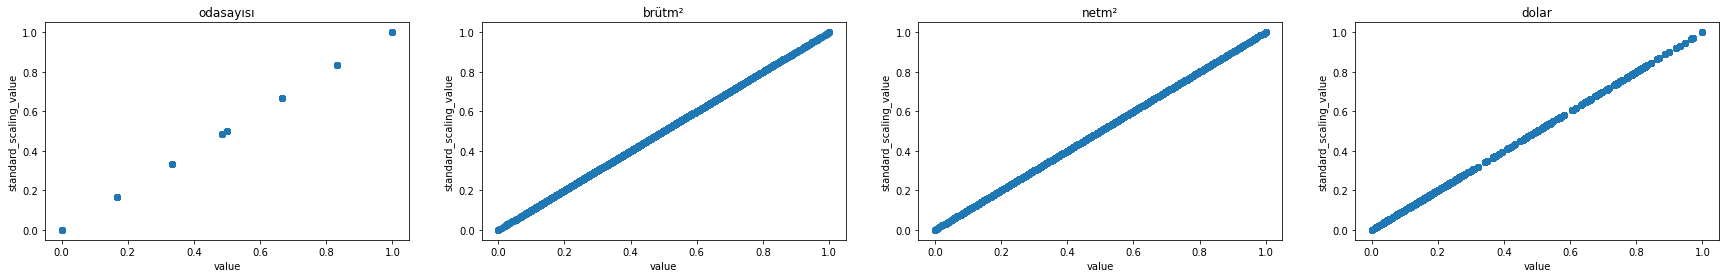

In [ ]:
plt.figure(figsize=(30,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.scatter(features_df[numerical_columns[i]], features_df[numerical_columns[i]])
    plt.title(numerical_columns[i])
    plt.xlabel("value")
    plt.ylabel("standard_scaling_value")

## 4.8 Korealasyonu yüksek sütunların drop edilmesi

In [ ]:
corr_matrix = features_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

features_df =  features_df.drop(to_drop, axis=1)
features_df.shape

(99700, 124)

## 4.9 Case 1 PCA -------- Case 2 Non PCA
Case 2 seçildi.

In [ ]:
"""pca = PCA(.95)
pca.fit(features_df)
features_df = pca.transform(features_df)
print(pca.n_components_)
features_df = pd.DataFrame(features_df)"""

'pca = PCA(.95)\npca.fit(features_df)\nfeatures_df = pca.transform(features_df)\nprint(pca.n_components_)\nfeatures_df = pd.DataFrame(features_df)'

# 5.Model Training

## 5.1 Train test split (En başta verilen veri setlerindekine uygun şekilde ayrıldı.)

In [ ]:
Y_train = train_label_set["guncel_fiyat"]
X_train = features_df.iloc[:64573,:]
X_test = features_df.iloc[64573:,:]
# Verinin bu şekilde bölünmesi istendiğinden çapraz doğrulamaya gerek yok.

## 5.2 Grid Search ile parametre seçimi

In [ ]:
DTC_Regressor = DecisionTreeRegressor()
DTC_params= {"criterion":["squared_error"], "min_samples_split": [2, 3, 4], "min_samples_leaf": [1, 2, 4], "max_depth": [None, 3, 5]}
DTC_grid_cv = GridSearchCV(DTC_Regressor, param_grid=DTC_params)
DTC_grid_cv.fit(X_train, Y_train)
print("Decision Tree")
print("")
print("En iyi parametreler : ", DTC_grid_cv.best_params_)
print("En iyi skor         : ", DTC_grid_cv.best_score_)

xgb_Regressor = XGBRegressor()
xgb_params= {"min_child_weight": [1, 5, 10], "max_depth": [3,4], "colsample_bytree": [0.6, 1.0], "learning_rate":[0.1, 0.3], "n_jobs": [-1], "objective":['reg:squarederror'], "tree_method":['gpu_hist'], "gpu_id":[0]}
xgb_grid_cv = GridSearchCV(xgb_Regressor, param_grid=xgb_params)
xgb_grid_cv.fit(X_train, Y_train)
print("XGBOOST")
print("")
print("En iyi parametreler : ", xgb_grid_cv.best_params_)
print("En iyi skor         : ", xgb_grid_cv.best_score_)

rf_Regressor = RandomForestRegressor()
rf_params= {"n_estimators":[70, 100, 130], "min_samples_leaf": [1, 2, 4], "min_samples_split": [2, 5, 10], "n_jobs": [-1]}
rf_grid_cv = GridSearchCV(rf_Regressor, param_grid=rf_params)
rf_grid_cv.fit(X_train, Y_train)
print("Random Forest")
print("")
print("En iyi parametreler : ", rf_grid_cv.best_params_)
print("En iyi skor         : ", rf_grid_cv.best_score_)

KNN_Regressor = KNeighborsRegressor()
KNN_params= {"n_neighbors":[3,4,5,6,7], "n_jobs": [-1], "weights":["uniform", "distance"]}
KNN_grid_cv = GridSearchCV(KNN_Regressor, param_grid=KNN_params)
KNN_grid_cv.fit(X_train, Y_train)
print("KNN")
print("")
print("En iyi parametreler : ", KNN_grid_cv.best_params_)
print("En iyi skor         : ", KNN_grid_cv.best_score_)

Decision Tree

En iyi parametreler :  {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
En iyi skor         :  0.41082439749084265
XGBOOST

En iyi parametreler :  {'colsample_bytree': 0.6, 'gpu_id': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_jobs': -1, 'objective': 'reg:squarederror', 'tree_method': 'gpu_hist'}
En iyi skor         :  0.505247331857466
Random Forest

En iyi parametreler :  {'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 130, 'n_jobs': -1}
En iyi skor         :  0.4315065127623683
KNN

En iyi parametreler :  {'n_jobs': -1, 'n_neighbors': 7, 'weights': 'uniform'}
En iyi skor         :  0.45566671798264924


Yukarıdaki sonuçlara göre XGBOOST Modeline odaklanıldı.

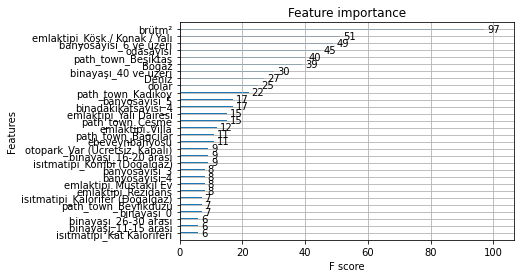

In [ ]:
xgb_r = XGBRegressor(tree_method="gpu_hist", learning_rate=0.1, max_depth=3, colsample_bytree=0.6, min_child_weight=1, silent=0, subsample=0.9, gpu_id=0, objective="reg:squarederror")
xgb_r.fit(X_train, Y_train)
xgb.plot_importance(xgb_r,max_num_features=30)

## 5.3 Training

In [ ]:
xgb_r = XGBRegressor(tree_method="gpu_hist", learning_rate=0.1, max_depth=3, colsample_bytree=0.6, min_child_weight=1, silent=0, subsample=0.9, gpu_id=0, objective="reg:squarederror")
xgb_r.fit(X_train, Y_train)

knn = KNeighborsRegressor(n_neighbors=7, weights="uniform")
knn.fit(X_train, Y_train)

dec_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=2)
dec_tree.fit(X_train, Y_train)

rf = RandomForestRegressor(n_estimators=130, min_samples_leaf=4, min_samples_split=10)
rf.fit(X_train, Y_train)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=10,
                      n_estimators=130)

# 6.Model Evaluating

In [ ]:
models = []
models.append(('XGBOOST', xgb_r))
models.append(("KNN", knn))
models.append(("Decision Tree", dec_tree))
models.append(("Random Forest", rf))

for i, v in models:

    prediction_train = v.predict(X_train)

    print(f"----------------------------- {i} Model Evaluation -----------------------------")
    print("Eğitim kümesi R-Kare değeri       : {}".format(v.score(X_train, Y_train)))
    print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(Y_train, prediction_train)))
    print("Ortalama Kare Hata (MSE)          : {}".format(mse(Y_train, prediction_train)))
    print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(Y_train, prediction_train)))
    print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((Y_train - prediction_train) / Y_train)) * 100))

----------------------------- XGBOOST Model Evaluation -----------------------------
Eğitim kümesi R-Kare değeri       : 0.6401663025244299
Ortalama Mutlak Hata (MAE)        : 423754.587240308
Ortalama Kare Hata (MSE)          : 9337664930292.309
Kök Ortalama Kare Hata (RMSE)     : 3055759.305032435
Ortalama Mutlak Yüzde Hata (MAPE) : 107.1629285812378
----------------------------- KNN Model Evaluation -----------------------------
Eğitim kümesi R-Kare değeri       : 0.5653078172909465
Ortalama Mutlak Hata (MAE)        : 343078.6994984635
Ortalama Kare Hata (MSE)          : 11280238561398.547
Kök Ortalama Kare Hata (RMSE)     : 3358606.639872932
Ortalama Mutlak Yüzde Hata (MAPE) : 62.428095270641585
----------------------------- Decision Tree Model Evaluation -----------------------------
Eğitim kümesi R-Kare değeri       : 0.599245049204486
Ortalama Mutlak Hata (MAE)        : 466623.38746988104
Ortalama Kare Hata (MSE)          : 10399569234169.213
Kök Ortalama Kare Hata (RMSE)     : 

# 7.Submission to Kaggle

In [ ]:
pred = xgb_r.predict(X_test)

In [ ]:
submission = pd.read_csv(root + 'sample_submission_zingat.csv')
submission.drop("Expected", axis=1, inplace=True)

In [ ]:
submission["Expected"] = pred

In [ ]:
submission.to_csv(root+'Outputs/Output6.csv', index = False)

# 8.Conclusion

* (1.Data)Veri setini yükledikten sonra ilk olarak veri setinin genel yapısı incelenmiştir. Train ve Test veri setleri önişlemler için birleştirilmiştir. Label içeren veri burada ayrılmıştır.


* (2.Data Cleaning) Veri setinde en başta eksik veri bulunmamaktadır. Ama bazı kolonlarda "-" şeklinde eksik veriler bulundu. Bu eksiklikler mean veya mod alınarak giderildi. Veri setinde outlayerlar tespit edildi. Bunlarda ya winsorize ya da logaritma alınarak giderildi.


* (3.Data Exploration) Tek değişkenli ve çok değişkenli analiz yapılmıştır. Korealasyon matrisi oluşturulup hedef değişkenimiz ile korele olan sürekli ve kategorik değişkenler görülmüştür. Verilerde normal dağılıma sahip olmayan değişken görülmüş olup bunlar normal dağılıma dönüştürülmüştür.


* (4.Feature Engineering) 
  * Dışarıdan veri seti olarak dolar veri seti yüklendi tarihle bağlantılı olarak dolar veri seti eklendi. 
  * Path kolonunda ilçe isimleri seçildi. 
  * Manzara kolonu için multilabelbinarizer işlemi uygulandı. 
  * Binary veri içeren kolonlar 0,1 formatına alındı. 
  * İstenen kolonlar birleştirildi.
  * Kategorik değişkenler dummy encode ile encode edildi.
  * Verilere case 1 olarak normalization case 2 olarak standard scalization uygulandı. Sonuç olarak case 2 nin daha iyi sonuç verdiği görülmüştür.
  * Birbiriyle yüksek korealasyonu olan sütunlar drop edilmiştir.
  * Case 1 olarak PCA uygulanmıştır. Case 2 olarak PCA uygulanmamıştır. Sonuç olarak Case 2 nin daha iyi sonuç verdiği görülmüştür.


* (5.Model Training)
  * Train test split manuel olarak uygulanmıştır. En başta veri train ve test ayrı olarak verilmişti. Bu duruma uygun olarak veriler ayrılmıştır. Y_test verisi, verilen veri setlerinde bulunmamaktadır. O yüzden işlemler buna uygun olarak yapılmıştır.
  * Grid Search ile model parametreleri denenmiştir. En uygun sonuç veren xgboost algoritması oldu. Xgboostun feature importance grafiği çizilmiştir.
  * Grid Search de elde edilen en uygun parametreler ile modeller eğitilmiştir.


* (6.Model Evaluating) Modellerin R kare, MAE, MSE, RMSE, MAPE değerleri bulunmuştur. Problemde istenen metrik RMSE dir. O yüzden en düşük RMSE değerine bakılmıştır. Burdada en iyi sonucu Xgboost vermiştir.

* (7.Submission to Kaggle) Elde edilen predictionlar Kaggle yarışmasına yüklenmek üzere csv dosyasına yazılmıştır.
